<a href="https://colab.research.google.com/github/VittorLeandro/ANALISE-DE-DADOS---ACIDENTES-PRF2024/blob/main/ANALISE_DE_DADOS_ACIDENTES_PRF2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas matplotlib seaborn nltk scikit-learn

In [2]:
import pandas as pd

# Subir o arquivo no Colab
from google.colab import files
uploaded = files.upload()

# Ler o CSV
dados = pd.read_csv("datatran2024_FonteDEDados.csv", sep=";", encoding="latin1")
dados.head()


Saving datatran2024_FonteDEDados.csv to datatran2024_FonteDEDados.csv


<ipython-input-2-32a0ea6dfe47>:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  dados = pd.read_csv("datatran2024_FonteDEDados.csv", sep=";", encoding="latin1")


id data_inversa     dia_semana   horario  uf   br   km  \
0  571789   01/01/2024  segunda-feira  03:56:00  ES  101   38   
1  571804   01/01/2024  segunda-feira  04:50:00  PI  343  185   
2  571806   01/01/2024  segunda-feira  04:30:00  BA  116  578   
3  571818   01/01/2024  segunda-feira  06:30:00  SE  101   18   
4  571838   01/01/2024  segunda-feira  05:00:00  MT  364  240   

            municipio                                     causa_acidente  \
0  CONCEICAO DA BARRA                             Ultrapassagem Indevida   
1            PIRIPIRI                        Manobra de mudan√ßa de faixa   
2             BREJOES                   Ingest√£o de √°lcool pelo condutor   
3    MALHADA DOS BOIS           Rea√ß√£o tardia ou ineficiente do condutor   
4        RONDONOPOLIS  Condutor deixou de manter dist√¢ncia do ve√≠culo...   

                    tipo_acidente  ... feridos_graves ilesos ignorados  \
0  Colis√£o lateral sentido oposto  ...              1      1         1   
1                 Colis√£o frontal  ...              0      1         0   
2                 Colis√£o frontal  ...              0      1         2   
3       Sa√≠da de leito carro√ß√°vel  ...              1      0         2   
4                Colis√£o traseira  ...              0      2         1   

  feridos veiculos      latitude     longitude  regional  delegacia  \
0       1        3     -18,48261     -39,92379   SPRF-ES   DEL04-ES   
1       0        2   -4,29603281  -41,76732659   SPRF-PI   DEL02-PI   
2       0        4  -13,07158302   -39,9611107   SPRF-BA   DEL03-BA   
3       1        3  -10,35601949  -36,90552235   SPRF-SE   DEL02-SE   
4       0        3  -16,17914141  -54,78905337   SPRF-MT   DEL02-MT   

              uop  
0  UOP02-DEL04-ES  
1  UOP01-DEL02-PI  
2  UOP02-DEL03-BA  
3  UOP02-DEL02-SE  
4  UOP01-DEL02-MT  

[5 rows x 30 columns]

In [5]:
# Selecionar colunas √∫teis
dados_limpos = dados[['condicao_metereologica', 'tipo_pista', 'horario', 'tipo_acidente', 'mortos']].copy()

# Tratar hor√°rio
dados_limpos['hora'] = dados_limpos['horario'].str.slice(0, 2).astype(str)

# Remover valores inv√°lidos
dados_limpos = dados_limpos.dropna()


In [6]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')
stopwords_pt = stopwords.words('portuguese')

# An√°lise das palavras mais comuns nos tipos de acidente
vectorizer = CountVectorizer(stop_words=stopwords_pt)
X = vectorizer.fit_transform(dados_limpos['tipo_acidente'])

# Frequ√™ncia das palavras
frequencia = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
frequencia.sum().sort_values(ascending=False).head(10)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


colis√£o        35699
traseira       11638
leito           8791
carro√ß√°vel      8791
sa√≠da           8791
lateral         8209
sentido         8209
transversal     7761
tombamento      5311
objeto          4140
dtype: int64

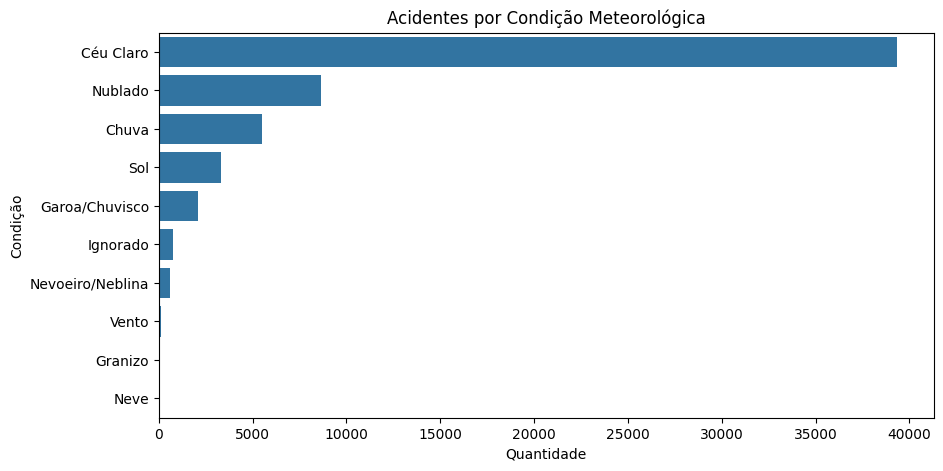

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.countplot(data=dados_limpos, y='condicao_metereologica', order=dados_limpos['condicao_metereologica'].value_counts().index)
plt.title('Acidentes por Condi√ß√£o Meteorol√≥gica')
plt.xlabel('Quantidade')
plt.ylabel('Condi√ß√£o')
plt.show()


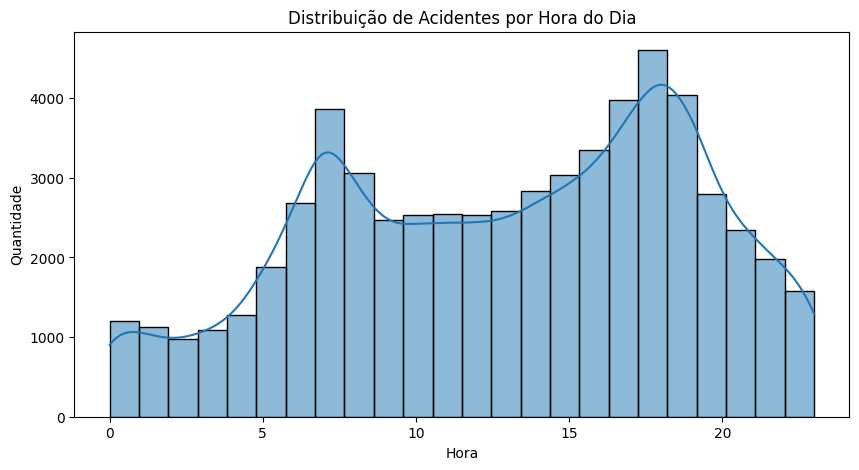

In [8]:
dados_limpos['hora'] = dados_limpos['hora'].astype(int)
plt.figure(figsize=(10,5))
sns.histplot(data=dados_limpos, x='hora', bins=24, kde=True)
plt.title('Distribui√ß√£o de Acidentes por Hora do Dia')
plt.xlabel('Hora')
plt.ylabel('Quantidade')
plt.show()


In [9]:
dados_seguro = dados_limpos.drop(columns=['latitude', 'longitude'], errors='ignore')


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Codificar vari√°veis categ√≥ricas
dados_encoded = pd.get_dummies(dados_seguro.drop(columns=['mortos']))
y = (dados_seguro['mortos'] > 0).astype(int)

# Dividir dados
X_train, X_test, y_train, y_test = train_test_split(dados_encoded, y, test_size=0.3, random_state=42)

# Modelo
modelo = RandomForestClassifier()
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

# Avaliar
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.93      0.98      0.96     16841
           1       0.27      0.09      0.14      1269

    accuracy                           0.92     18110
   macro avg       0.60      0.54      0.55     18110
weighted avg       0.89      0.92      0.90     18110



In [11]:
from imblearn.over_sampling import SMOTE
X_res, y_res = SMOTE().fit_resample(X_train, y_train)


<ipython-input-13-720532b06e6c>:6: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  dados = pd.read_csv("datatran2024_FonteDEDados.csv", sep=";", encoding="latin1")
<ipython-input-13-720532b06e6c>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=acidentes_estado, x='uf', y='taxa_fatalidade', palette='Reds_r')


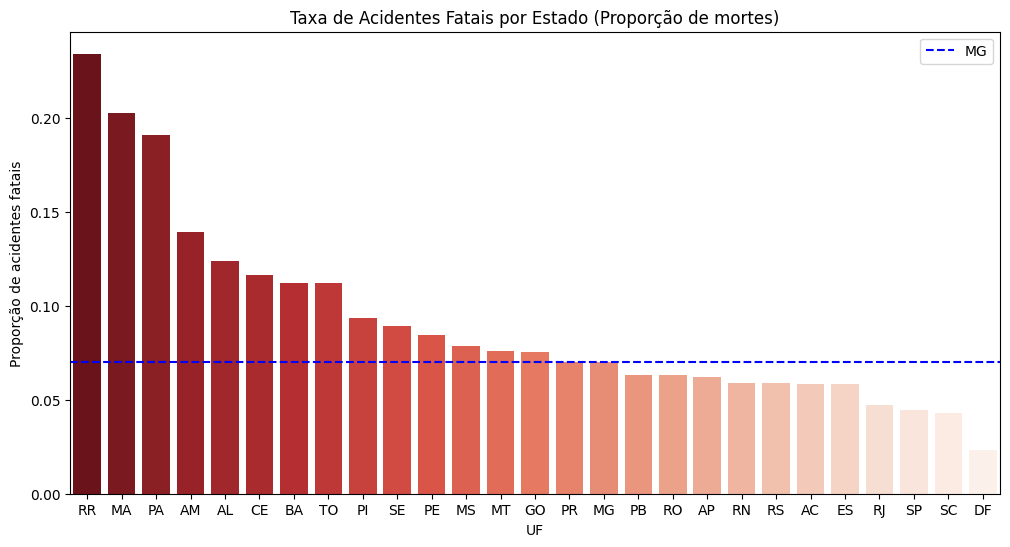

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Carregar os dados
dados = pd.read_csv("datatran2024_FonteDEDados.csv", sep=";", encoding="latin1")

# Criar nova coluna: acidente com morte (1) ou n√£o (0)
dados['acidente_fatal'] = (dados['mortos'] > 0).astype(int)

# Agrupar por estado (UF)
acidentes_estado = dados.groupby('uf').agg({
    'id': 'count',
    'acidente_fatal': 'sum',
    'veiculos': 'sum'
}).reset_index().rename(columns={'id': 'total_acidentes'})

# Calcular taxa de acidentes fatais
acidentes_estado['taxa_fatalidade'] = acidentes_estado['acidente_fatal'] / acidentes_estado['total_acidentes']
acidentes_estado = acidentes_estado.sort_values(by='taxa_fatalidade', ascending=False)

# Visualizar compara√ß√£o
plt.figure(figsize=(12,6))
sns.barplot(data=acidentes_estado, x='uf', y='taxa_fatalidade', palette='Reds_r')
plt.title("Taxa de Acidentes Fatais por Estado (Propor√ß√£o de mortes)")
plt.ylabel("Propor√ß√£o de acidentes fatais")
plt.xlabel("UF")
plt.axhline(y=acidentes_estado[acidentes_estado['uf'] == 'MG']['taxa_fatalidade'].values[0], color='blue', linestyle='--', label='MG')
plt.legend()
plt.show()


              precision    recall  f1-score   support

           0       0.96      0.62      0.76     16841
           1       0.11      0.63      0.19      1269

    accuracy                           0.62     18110
   macro avg       0.53      0.63      0.47     18110
weighted avg       0.90      0.62      0.72     18110



<ipython-input-14-d0ae6dbdca4a>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importancia_df.head(10), x='importancia', y='variavel', palette='Blues_d')


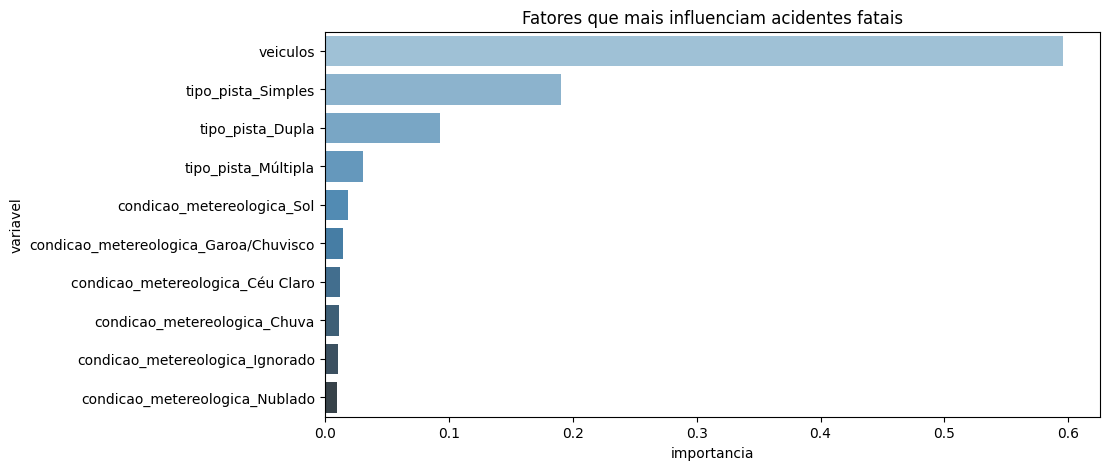

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np

# Selecionar colunas √∫teis
dados_modelo = dados[['veiculos', 'tipo_pista', 'condicao_metereologica', 'acidente_fatal']].dropna()

# Codificar vari√°veis categ√≥ricas
dados_modelo_encoded = pd.get_dummies(dados_modelo.drop(columns=['acidente_fatal']))
y = dados_modelo['acidente_fatal']

# Dividir
X_train, X_test, y_train, y_test = train_test_split(dados_modelo_encoded, y, test_size=0.3, random_state=42)

# Treinar modelo
modelo = RandomForestClassifier(class_weight='balanced')
modelo.fit(X_train, y_train)

# Avaliar
y_pred = modelo.predict(X_test)
print(classification_report(y_test, y_pred))

# Import√¢ncia dos atributos
importances = modelo.feature_importances_
importancia_df = pd.DataFrame({'variavel': X_train.columns, 'importancia': importances})
importancia_df = importancia_df.sort_values(by='importancia', ascending=False)

# Gr√°fico da import√¢ncia
plt.figure(figsize=(10,5))
sns.barplot(data=importancia_df.head(10), x='importancia', y='variavel', palette='Blues_d')
plt.title("Fatores que mais influenciam acidentes fatais")
plt.show()


In [15]:
import pandas as pd
import plotly.express as px

# Carregar os dados
dados = pd.read_csv("datatran2024_FonteDEDados.csv", sep=";", encoding="latin1")

# Criar coluna de acidente fatal
dados['acidente_fatal'] = (dados['mortos'] > 0).astype(int)

# Agrupar dados por estado
resumo_uf = dados.groupby('uf').agg({
    'id': 'count',
    'acidente_fatal': 'sum',
    'veiculos': 'sum'
}).reset_index().rename(columns={'id': 'total_acidentes'})

# Calcular taxa de fatalidade
resumo_uf['taxa_fatalidade'] = resumo_uf['acidente_fatal'] / resumo_uf['total_acidentes']

# Gr√°fico interativo tipo dashboard com Plotly
fig = px.scatter(resumo_uf,
                 x='veiculos',
                 y='acidente_fatal',
                 size='total_acidentes',
                 color='uf',
                 hover_name='uf',
                 text='uf',
                 size_max=60,
                 labels={
                     'veiculos': 'Total de Ve√≠culos Envolvidos',
                     'acidente_fatal': 'Acidentes com Morte',
                     'uf': 'Estado (UF)'
                 },
                 title="Resumo Comparativo: Ve√≠culos x Acidentes Fatais por Estado (2024)"
                )

fig.update_traces(textposition='top center')
fig.update_layout(template='plotly_white', height=600)
fig.show()


<ipython-input-15-4869c431f4e4>:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  dados = pd.read_csv("datatran2024_FonteDEDados.csv", sep=";", encoding="latin1")


In [16]:
# Instalar
!pip install streamlit

# Arquivo: app.py
import pandas as pd
import plotly.express as px
import streamlit as st

dados = pd.read_csv("datatran2024_FonteDEDados.csv", sep=";", encoding="latin1")
dados['acidente_fatal'] = (dados['mortos'] > 0).astype(int)

resumo = dados.groupby('uf').agg({
    'id': 'count',
    'acidente_fatal': 'sum',
    'veiculos': 'sum'
}).reset_index().rename(columns={'id': 'total_acidentes'})
resumo['taxa_fatalidade'] = resumo['acidente_fatal'] / resumo['total_acidentes']

fig = px.bar(resumo, x='uf', y='taxa_fatalidade', title='Taxa de Acidentes Fatais por Estado')

st.title("Dashboard Interativo - Acidentes de Tr√¢nsito")
st.plotly_chart(fig)


     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 44.3/44.3 kB 3.0 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9.9/9.9 MB 97.0 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6.9/6.9 MB 85.7 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 79.1/79.1 kB 5.9 MB/s eta 0:00:00


<ipython-input-16-dda3c43d860e>:9: DtypeWarning:

Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.

2025-06-03 13:25:39.506 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-03 13:25:39.677 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-06-03 13:25:39.678 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-03 13:25:39.682 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-03 13:25:39.683 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-03 13:25:39.686 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-03 13:25:39.687 Thread 'Main

DeltaGenerator()

In [18]:
!pip install streamlit pyngrok --quiet

# Escreve o c√≥digo do app.py
app_code = '''
import pandas as pd
import streamlit as st
import plotly.express as px

st.set_page_config(page_title="AN√ÅLISE DE DADOS - ACIDENTES PRF.2024", layout="wide")
st.title("üö® AN√ÅLISE DE DADOS - ACIDENTES PRF.2024")

@st.cache_data
def carregar_dados():
    return pd.read_csv("datatran2024_FonteDEDados.csv", sep=";", encoding="latin1")

dados = carregar_dados()

colunas_utilizadas = [
    "uf", "tipo_acidente", "condicao_metereologica",
    "mortos", "veiculos", "feridos", "data_inversa"
]
dados = dados[colunas_utilizadas]
dados["data_inversa"] = pd.to_datetime(dados["data_inversa"], errors="coerce")

mortos_por_uf = dados.groupby("uf")["mortos"].sum().reset_index()
veiculos_por_uf = dados.groupby("uf")["veiculos"].sum().reset_index()
acidentes_por_uf = dados.groupby("uf").size().reset_index(name="total_acidentes")

comparativo_uf = mortos_por_uf.merge(veiculos_por_uf, on="uf").merge(acidentes_por_uf, on="uf")
comparativo_uf["taxa_mortalidade"] = comparativo_uf["mortos"] / comparativo_uf["total_acidentes"]
comparativo_uf["veiculos_por_acidente"] = comparativo_uf["veiculos"] / comparativo_uf["total_acidentes"]

fig1 = px.bar(comparativo_uf.sort_values("mortos", ascending=False),
              x="uf", y="mortos", color="mortos",
              title="Total de Mortes por Estado (UF)", color_continuous_scale="Reds")
st.plotly_chart(fig1, use_container_width=True)

fig2 = px.scatter(comparativo_uf, x="veiculos_por_acidente", y="taxa_mortalidade",
                  color="uf", size="total_acidentes", hover_name="uf",
                  title="Correla√ß√£o entre Ve√≠culos por Acidente e Mortalidade")
st.plotly_chart(fig2, use_container_width=True)

st.subheader("üîé An√°lise Preventiva")
st.markdown(\"""
Minas Gerais apresenta o maior n√∫mero absoluto de mortes, possivelmente devido a:
- Rodovias extensas e perigosas;
- Alto fluxo de ve√≠culos;
- Fatores clim√°ticos e de infraestrutura.

A rela√ß√£o entre ve√≠culos e taxa de mortalidade sugere:
- Maior n√∫mero de ve√≠culos pode elevar a gravidade dos acidentes;
- Investimentos em preven√ß√£o e fiscaliza√ß√£o s√£o essenciais.
\""")
st.caption("Fonte: PRF (2024) - An√°lise de Vitor Leandro.")
'''

with open("app.py", "w", encoding="utf-8") as f:
    f.write(app_code)


In [19]:
from google.colab import files
uploaded = files.upload()


Saving datatran2024_FonteDEDados.csv to datatran2024_FonteDEDados (1).csv


In [21]:
!ngrok config add-authtoken 2y08VUayeM3N0JTokRsFIjcGafL_2G3BYGYuPw8n398eH6F4


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [23]:
import os
import time
from pyngrok import ngrok

# Roda o Streamlit em segundo plano
!streamlit run app.py &>/content/log.txt &

# Espera o app carregar
time.sleep(5)

# Cria t√∫nel corretamente com nova sintaxe
public_url = ngrok.connect("http://localhost:8501")
print(f"üåê Acesse seu Dashboard aqui: {public_url}")


üåê Acesse seu Dashboard aqui: NgrokTunnel: "https://493b-34-21-26-75.ngrok-free.app" -> "http://localhost:8501"
